# Importing libraries


In [4]:
!pip install pyspark
!pip install kaggle

In [5]:
import os
import zipfile
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, split, explode, collect_set, regexp_replace, count
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as F
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Uploading the dataset

In [6]:
# Setup Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = "oumamn"
os.environ['KAGGLE_KEY'] = "97ed9542d08db7d6055d910285634307"

# Downloading the dataset
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

# Unzipping the dataset
with zipfile.ZipFile('1-3m-linkedin-jobs-and-skills-2024.zip', 'r') as zip_ref:
    zip_ref.extractall('linkedin_jobs_dataset')

# Creating a SparkSession
spark = SparkSession.builder \
    .appName("MarketBasketAnalysis") \
    .getOrCreate()

# Loading the dataset
file_path = 'linkedin_jobs_dataset/job_skills.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
1-3m-linkedin-jobs-and-skills-2024.zip: Skipping, found more recently modified local copy (use --force to force download)


# Data Exploration

In [7]:
df.count()

1296381

In [8]:
df.show(3)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
+--------------------+--------------------+
only showing top 3 rows



In [9]:
df.select('job_skills').show(1, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_skills                                                                                                                                                                                                                                                                      |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety P

In [10]:
df.select('job_link').show(1, truncate=False)

+-----------------------------------------------------------------------------------------------+
|job_link                                                                                       |
+-----------------------------------------------------------------------------------------------+
|https://www.linkedin.com/jobs/view/housekeeper-i-pt-at-jacksonville-state-university-3802280436|
+-----------------------------------------------------------------------------------------------+
only showing top 1 row



In [11]:
unique_skills_count = df.selectExpr("explode(split(job_skills, ', ')) as skill").distinct().count()
print(f'The dataset contains {unique_skills_count} unique skills.')

The dataset contains 3298454 unique skills.


# Data Preprocessing

In [12]:
# Removing null values
df = df.filter(col('job_skills').isNotNull() & (trim(col('job_skills')) != ''))

# Normalizing text: convert to lowercase, trim whitespace, and replace multiple spaces with a single space
df = df.withColumn('job_skills', lower(trim(col('job_skills'))))
df = df.withColumn('job_skills', regexp_replace(col('job_skills'), r'\s+', ' '))

# Removing punctuation
df = df.withColumn('job_skills', regexp_replace(col('job_skills'), r'[^\w\s,]', ''))

# Splitting the job_skills column into an array of skills
df = df.withColumn('skills', split(col('job_skills'), ','))

In [13]:
# Exploding the skills array into individual rows
df_exploded = df.withColumn('skill', explode(col('skills')))
df_exploded = df_exploded.withColumn('skill', lower(trim(col('skill'))))

In [14]:
# Grouping by job_id and collect skills into a set
df_baskets = df_exploded.groupBy('job_link').agg(collect_set('skill').alias('skills'))

In [15]:
# Frequent itemset mining using FPGrowth
fpGrowth = FPGrowth(itemsCol='skills', minSupport=0.05, minConfidence=0.1)
model = fpGrowth.fit(df_baskets)

In [16]:
# Displaying the results
frequent_itemsets = model.freqItemsets
frequent_itemsets.show(20, truncate=False)

+---------------------------------+------+
|items                            |freq  |
+---------------------------------+------+
|[microsoft office suite]         |74952 |
|[project management]             |120177|
|[communication]                  |366270|
|[customer service]               |276788|
|[customer service, communication]|139202|
|[interpersonal skills]           |99943 |
|[inventory management]           |71614 |
|[patient care]                   |99454 |
|[teamwork]                       |226212|
|[teamwork, customer service]     |91091 |
|[teamwork, communication]        |139320|
|[bachelors degree]               |68089 |
|[high school diploma]            |67297 |
|[communication skills]           |195249|
|[sales]                          |92744 |
|[nursing]                        |87833 |
|[leadership]                     |183839|
|[leadership, customer service]   |66588 |
|[leadership, communication]      |117281|
|[problem solving]                |146164|
+----------

In [17]:
association_rules = model.associationRules
association_rules.show(20, truncate=False)

+---------------------+---------------------+-------------------+------------------+--------------------+
|antecedent           |consequent           |confidence         |lift              |support             |
+---------------------+---------------------+-------------------+------------------+--------------------+
|[problemsolving]     |[communication]      |0.7064808844575149 |2.4966568060141734|0.06941270451971378 |
|[communication]      |[customer service]   |0.3800529663909138 |1.7772832576530508|0.1075438783535516  |
|[communication]      |[teamwork]           |0.3803751330985339 |2.17648790749068  |0.10763504211302143 |
|[communication]      |[leadership]         |0.32020367488464796|2.2544906764894352|0.09060827859644895 |
|[communication]      |[problem solving]    |0.25729106942965574|2.2784739792420927|0.07280585055015011 |
|[communication]      |[time management]    |0.2303055123269719 |2.0971203760356243|0.06516972683320277 |
|[communication]      |[attention to detail]|0

In [18]:
frequent_itemsets.show(30)

+--------------------+------+
|               items|  freq|
+--------------------+------+
|[microsoft office...| 74952|
|[project management]|120177|
|     [communication]|366270|
|  [customer service]|276788|
|[customer service...|139202|
|[interpersonal sk...| 99943|
|[inventory manage...| 71614|
|      [patient care]| 99454|
|          [teamwork]|226212|
|[teamwork, custom...| 91091|
|[teamwork, commun...|139320|
|  [bachelors degree]| 68089|
|[high school dipl...| 67297|
|[communication sk...|195249|
|             [sales]| 92744|
|           [nursing]| 87833|
|        [leadership]|183839|
|[leadership, cust...| 66588|
|[leadership, comm...|117281|
|   [problem solving]|146164|
|[problem solving,...| 94238|
|     [collaboration]| 86276|
|   [time management]|142148|
|[time management,...| 84354|
|          [training]| 82754|
|     [data analysis]| 80922|
|[attention to det...|132784|
|[attention to det...| 65774|
|    [problemsolving]|127174|
|[problemsolving, ...| 89846|
+---------

In [19]:
frequent_itemsets.select('items').show(20, truncate=False)

+---------------------------------+
|items                            |
+---------------------------------+
|[microsoft office suite]         |
|[project management]             |
|[communication]                  |
|[customer service]               |
|[customer service, communication]|
|[interpersonal skills]           |
|[inventory management]           |
|[patient care]                   |
|[teamwork]                       |
|[teamwork, customer service]     |
|[teamwork, communication]        |
|[bachelors degree]               |
|[high school diploma]            |
|[communication skills]           |
|[sales]                          |
|[nursing]                        |
|[leadership]                     |
|[leadership, customer service]   |
|[leadership, communication]      |
|[problem solving]                |
+---------------------------------+
only showing top 20 rows



In [20]:
top_skills = df.select(explode(split(df.job_skills, ', ')).alias("skill")) \
               .groupBy("skill") \
               .agg(count("*").alias("frequency")) \
               .orderBy("frequency", ascending=False)

top_skills.show(10, truncate=False)

+--------------------+---------+
|skill               |frequency|
+--------------------+---------+
|communication       |370096   |
|customer service    |278080   |
|teamwork            |227559   |
|communication skills|195918   |
|leadership          |185168   |
|problem solving     |149009   |
|time management     |142887   |
|attention to detail |133942   |
|problemsolving      |129310   |
|project management  |121550   |
+--------------------+---------+
only showing top 10 rows



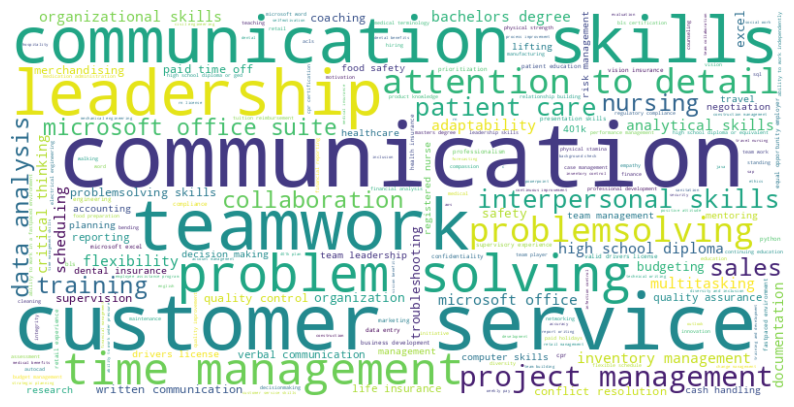

In [21]:
skill_freq_dict = {row['skill']: row['frequency'] for row in top_skills.collect()}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(skill_freq_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
top_30_items = frequent_itemsets.orderBy(F.desc('freq')).select('items', 'freq').limit(30)
top_30_items.show(truncate=False)

+---------------------------------+------+
|items                            |freq  |
+---------------------------------+------+
|[communication]                  |366270|
|[customer service]               |276788|
|[teamwork]                       |226212|
|[communication skills]           |195249|
|[leadership]                     |183839|
|[problem solving]                |146164|
|[time management]                |142148|
|[teamwork, communication]        |139320|
|[customer service, communication]|139202|
|[attention to detail]            |132784|
|[problemsolving]                 |127174|
|[project management]             |120177|
|[leadership, communication]      |117281|
|[interpersonal skills]           |99943 |
|[patient care]                   |99454 |
|[problem solving, communication] |94238 |
|[sales]                          |92744 |
|[teamwork, customer service]     |91091 |
|[problemsolving, communication]  |89846 |
|[nursing]                        |87833 |
+----------

In [23]:
# Ordering by confidence in descending order
ordered_by_confidence = association_rules.orderBy(F.desc('confidence'))

# The result
ordered_by_confidence.show(truncate=False)

+---------------------+---------------------+-------------------+------------------+--------------------+
|antecedent           |consequent           |confidence         |lift              |support             |
+---------------------+---------------------+-------------------+------------------+--------------------+
|[problemsolving]     |[communication]      |0.7064808844575149 |2.4966568060141734|0.06941270451971378 |
|[problem solving]    |[communication]      |0.644741523220492  |2.2784739792420923|0.07280585055015011 |
|[leadership]         |[communication]      |0.6379549497114323 |2.2544906764894352|0.09060827859644895 |
|[teamwork]           |[communication]      |0.6158824465545595 |2.1764879074906798|0.10763504211302143 |
|[time management]    |[communication]      |0.5934237555224132 |2.0971203760356243|0.06516972683320277 |
|[customer service]   |[communication]      |0.5029192016994957 |1.777283257653051 |0.1075438783535516  |
|[attention to detail]|[communication]      |0